**Importing essential libraries like Transformers, Evaluate, TQDM, Pandas, and Matplotlib for model evaluation.**

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_from_disk
import evaluate
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

**Loading the ROUGE and BERTScore metrics using Hugging Face’s evaluate package.**

In [3]:
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

**Defining a function to load a model and tokenizer from a given checkpoint path.**

In [5]:
def load_model_and_tokenizer(model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
    return model, tokenizer

**Defining a function to generate summaries using the model, applying truncation and decoding the output tokens.**

In [7]:
def generate_summaries(model, tokenizer, dataset, max_input_len=512, max_target_len=128):
    model.eval()
    summaries = []
    for item in tqdm(dataset):
        input_ids = tokenizer(item["input_text"], return_tensors="pt", truncation=True, max_length=max_input_len).input_ids
        output_ids = model.generate(input_ids=input_ids, max_new_tokens=max_target_len)[0]
        summary = tokenizer.decode(output_ids, skip_special_tokens=True)
        summaries.append(summary)
    return summaries

**Defining a function to calculate ROUGE scores between generated and reference summaries.**

In [9]:
def compute_rouge(predictions, references):
    return rouge.compute(predictions=predictions, references=references, use_stemmer=True)

**Defining a function to compute BERTScore (precision, recall, F1) for evaluating semantic similarity.**

In [11]:
def compute_bertscore(predictions, references):
    results = bertscore.compute(predictions=predictions, references=references, lang="en")
    return {
        "bertscore_precision": round(sum(results["precision"]) / len(results["precision"]) * 100, 2),
        "bertscore_recall": round(sum(results["recall"]) / len(results["recall"]) * 100, 2),
        "bertscore_f1": round(sum(results["f1"]) / len(results["f1"]) * 100, 2),
    }

**Defining a function to compute the average token length of predicted and reference summaries.**

In [13]:
def get_length_metrics(predictions, references):
    pred_lens = [len(p.split()) for p in predictions]
    ref_lens = [len(r.split()) for r in references]
    return {
        "avg_pred_len": round(sum(pred_lens) / len(pred_lens), 2),
        "avg_ref_len": round(sum(ref_lens) / len(ref_lens), 2),
    }

**Defining a function that loads a model checkpoint, generates summaries, computes all evaluation metrics, and returns a dictionary of results.**

In [15]:
def evaluate_model_from_checkpoint(checkpoint_path, test_dataset):
    model, tokenizer = load_model_and_tokenizer(checkpoint_path)

    input_texts = tokenizer.batch_decode(test_dataset["input_ids"], skip_special_tokens=True)
    reference_summaries = tokenizer.batch_decode(test_dataset["labels"], skip_special_tokens=True)

    generated_summaries = generate_summaries(model, tokenizer, [{"input_text": t} for t in input_texts])
    
    scores = compute_rouge(generated_summaries, reference_summaries)
    scores = {k: round(v * 100, 2) for k, v in scores.items()}

    scores.update(compute_bertscore(generated_summaries, reference_summaries))
    scores.update(get_length_metrics(generated_summaries, reference_summaries))
    
    return scores

**Evaluating multiple model checkpoints, storing results in a DataFrame, and displaying the results.**

In [17]:
checkpoint_dirs = [
    "../outputs/model/checkpoint-3500",
    "../outputs/model/checkpoint-7000",
    "../outputs/model/checkpoint-10500",
]

test_dataset = load_from_disk("../data/test")

results = {}
for ckpt in checkpoint_dirs:
    name = os.path.basename(ckpt)
    print(f"Evaluating {name}...")
    scores = evaluate_model_from_checkpoint(ckpt, test_dataset)
    results[name] = scores

results_df = pd.DataFrame(results).T
display(results_df)

Evaluating checkpoint-3500...


100%|█████████████████████████████████████| 1500/1500 [1:58:11<00:00,  4.73s/it]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating checkpoint-7000...


100%|█████████████████████████████████████| 1500/1500 [1:51:19<00:00,  4.45s/it]


Evaluating checkpoint-10500...


100%|█████████████████████████████████████| 1500/1500 [1:50:41<00:00,  4.43s/it]


,rouge1,rouge2,rougeL,rougeLsum,bertscore_precision,bertscore_recall,bertscore_f1,avg_pred_len,avg_ref_len
checkpoint-3500,35.03,14.42,22.72,32.62,85.72,88.78,87.21,99.01,51.71
checkpoint-7000,35.58,14.89,23.15,33.11,85.76,88.94,87.31,98.12,51.71
checkpoint-10500,36.14,15.33,23.71,33.72,85.76,88.92,87.30,94.11,51.71


**Plotting a grouped bar chart comparing ROUGE and BERTScore metrics for each evaluated checkpoint.**

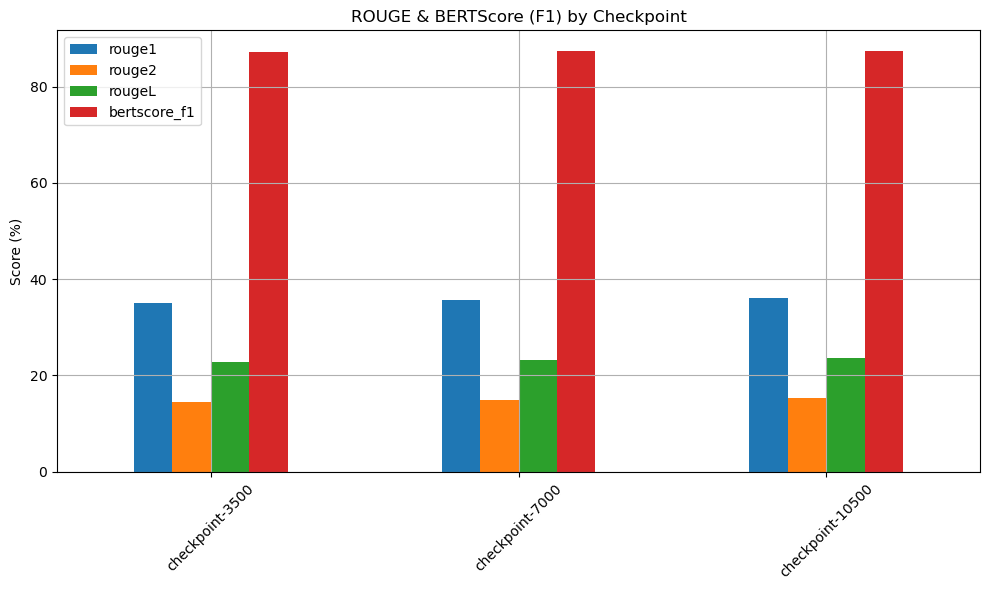

In [18]:
results_df[["rouge1", "rouge2", "rougeL", "bertscore_f1"]].plot(kind="bar", figsize=(10,6))
plt.title("ROUGE & BERTScore (F1) by Checkpoint")
plt.ylabel("Score (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Plotting a comparison of predicted vs reference summary lengths to evaluate verbosity or truncation issues.**

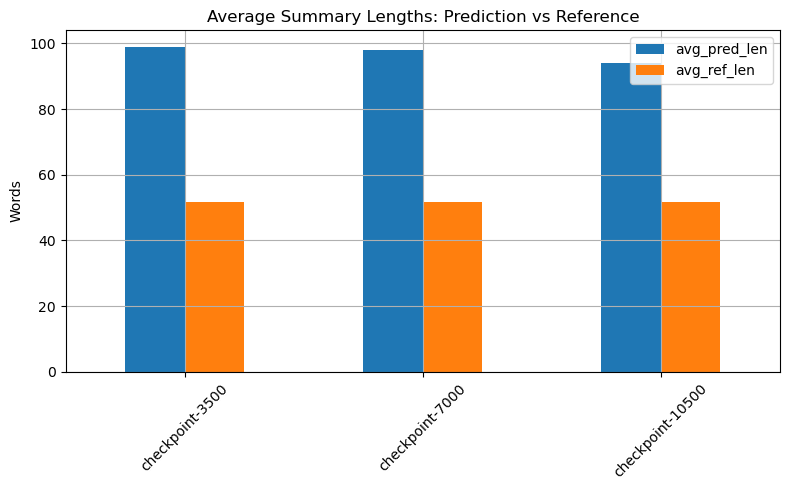

In [19]:
results_df[["avg_pred_len", "avg_ref_len"]].plot(kind="bar", figsize=(8,5))
plt.title("Average Summary Lengths: Prediction vs Reference")
plt.ylabel("Words")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()